This is a tutorial to use the flip package: https://github.com/corentinravoux/flip \
It is self-contained and can be used in google collab or on your environement \
All the data used are subsampled version of a simulation. \
The data size is small for the tutorial, do not use it for science case.

In [1]:
%%capture
!pip install git+https://github.com/corentinravoux/flip

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flip import fitter, plot_utils, utils, vectors
from flip.covariance import covariance, contraction
from pkg_resources import resource_filename
flip_base = resource_filename("flip", ".")
data_path = os.path.join(flip_base, "data")
plt.style.use(os.path.join(data_path,"style.mplstyle"))

[ 000000.00 ]: 03-01 02:07  root            INFO     No pypower module detected, gridding with this method is unavailable
[ 000000.43 ]: 03-01 02:07  jax._src.xla_bridge INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[ 000000.43 ]: 03-01 02:07  jax._src.xla_bridge INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[ 000000.43 ]: 03-01 02:07  jax._src.xla_bridge INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
[ 000000.43 ]: 03-01 02:07  jax._src.xla_bridge WARNING  An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/tmp/ipykernel_1056757/2340206863.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import r

# Select data

In [3]:
grid = pd.read_parquet(os.path.join(data_path,"density_data.parquet"))
grid_window = pd.read_parquet(os.path.join(data_path,"grid_window_m.parquet"))
coordinates_density = np.array([grid["ra"], grid["dec"], grid["rcom"]])
data_density = {'density': np.array(grid["density"]), 
                'density_error': np.array(grid["density_err"])}



sn_data = pd.read_parquet(os.path.join(data_path,"velocity_data.parquet"))

coordinates_velocity = np.array([sn_data["ra"], sn_data["dec"], sn_data["rcom_zobs"]])
data_velocity = sn_data.to_dict("list")
for key in data_velocity.keys():
    data_velocity[key] = np.array(data_velocity[key])
data_velocity["velocity"] = data_velocity.pop("vpec")
data_velocity["velocity_error"] = np.zeros_like(data_velocity["velocity"])

data_full = {}
data_full.update(data_density)
data_full.update(data_velocity)


sigmau_fiducial = 15.0
sigmag_fiducial = 3.0

ktt, ptt = np.loadtxt(os.path.join(data_path,"power_spectrum_tt.txt"))
kmt, pmt = np.loadtxt(os.path.join(data_path,"power_spectrum_mt.txt"))
kmm, pmm = np.loadtxt(os.path.join(data_path,"power_spectrum_mm.txt"))
power_spectrum_dict_bias = {"gg": [[kmm, pmm * np.array(grid_window["window_mm"])**2]]}
power_spectrum_dict = {"gg": [[kmm, pmm * np.array(grid_window["window_mm"])**2],[kmt, pmt * np.array(grid_window["window_mt"])],[ktt, ptt]],
                       "gv": [[kmt, pmt * np.array(grid_window["window_mt"])* utils.Du(kmt, sigmau_fiducial)],[ktt, ptt* utils.Du(kmt, sigmau_fiducial)]],
                       "vv": [[ktt, ptt * utils.Du(ktt, sigmau_fiducial)**2]]}

# Fit with true velocities

In [4]:
size_batch=10_000
number_worker=8

covariance_fit = covariance.CovMatrix.init_from_flip(
    "adamsblake20",
    "full",
    power_spectrum_dict,
    coordinates_density=coordinates_density,
    coordinates_velocity=coordinates_velocity,
    size_batch=size_batch,
    number_worker=number_worker,
    additional_parameters_values=(sigmag_fiducial,),
)

[ 000003.75 ]: 03-01 02:07  root            INFO     Covariance matrix generated from flip with adamsblake20 model in 3.47e+00 seconds


In [5]:
likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "inverse",
                         "velocity_type": "direct"}


parameter_dict = {"bs8": {"value": 1.0,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "beta_f": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 100,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                 }


minuit_fitter = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        data_full,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties)

minuit_fitter.run()


[ 000004.21 ]: 03-01 02:07  root            INFO     Iteration 1/1

[ 000373.85 ]: 03-01 02:14  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.525e+04                  │              Nfcn = 133              │
│ EDM = 3.87e-07 (Goal: 0.0002)    │           time = 369.6 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴───────

# Fit with estimated velocities

In [6]:
test_parameters = {"alpha":0.14,
                   "beta": 3.1,
                   "M_0": -19.133,
                   "sigma_M": 0.12}

velocity, velocity_error = vectors.get_velocity_from_salt_fit(
    data_velocity,
    test_parameters,
    "full",
)

mask = np.abs(velocity) < 3_000
mask &= velocity_error < 3_000

coordinates_velocity_cleaned = np.transpose(np.transpose(coordinates_velocity)[mask])
data_velocity_cleaned = {}
for key in list(data_velocity.keys()):
    data_velocity_cleaned[key] = data_velocity[key][mask]
    
data_full_cleaned = {}
data_full_cleaned.update(data_density)
data_full_cleaned.update(data_velocity_cleaned)


In [7]:
size_batch=10_000
number_worker=8

covariance_fit = covariance.CovMatrix.init_from_flip(
    "adamsblake20",
    "full",
    power_spectrum_dict,
    coordinates_density=coordinates_density,
    coordinates_velocity=coordinates_velocity_cleaned,
    size_batch=size_batch,
    number_worker=number_worker,
    additional_parameters_values=(sigmag_fiducial,),
)

[ 000376.88 ]: 03-01 02:14  root            INFO     Covariance matrix generated from flip with adamsblake20 model in 3.02e+00 seconds


In [8]:
likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "inverse",
                         "velocity_type": "saltfit",
                         "velocity_estimator": "full",
                        }

parameter_dict = {"bs8": {"value": 1.0,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "beta_f": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 100,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "alpha": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 0.25,
                          "fixed" : False,
                         },
                  "beta": {"value": 3.0,
                          "limit_low" : 2.5,
                          "limit_up" : 4.5,
                          "fixed" : False,
                         },
                  "M_0": {"value": -19,
                          "limit_low" : -21,
                          "limit_up" : -18,
                          "fixed" : False,
                         },
                  "sigma_M": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 100.0,
                          "fixed" : False,
                         },
                 }


minuit_fitter_velest = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        data_full_cleaned,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties)

minuit_fitter_velest.run()

/global/homes/r/ravouxco/.local/perlmutter/python-3.11/lib/python3.11/site-packages/iminuit/util.py:172: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
[ 000377.23 ]: 03-01 02:14  root            INFO     Iteration 1/1

[ 000938.55 ]: 03-01 02:23  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.566e+04                  │              Nfcn = 267              │
│ EDM = 7.31e-05 (Goal: 0.0002)    │           time = 561.3 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Bel

# Some plots

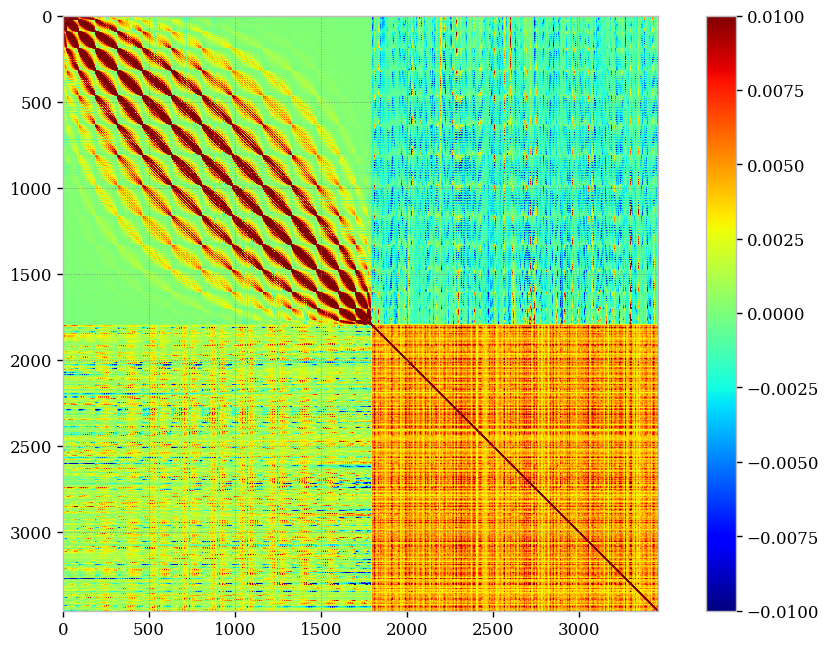

In [9]:
plot_utils.plot_correlation_from_likelihood(minuit_fitter_velest.likelihood,
                                            parameter_dict,
                                            vmin=-0.01,vmax=0.01)

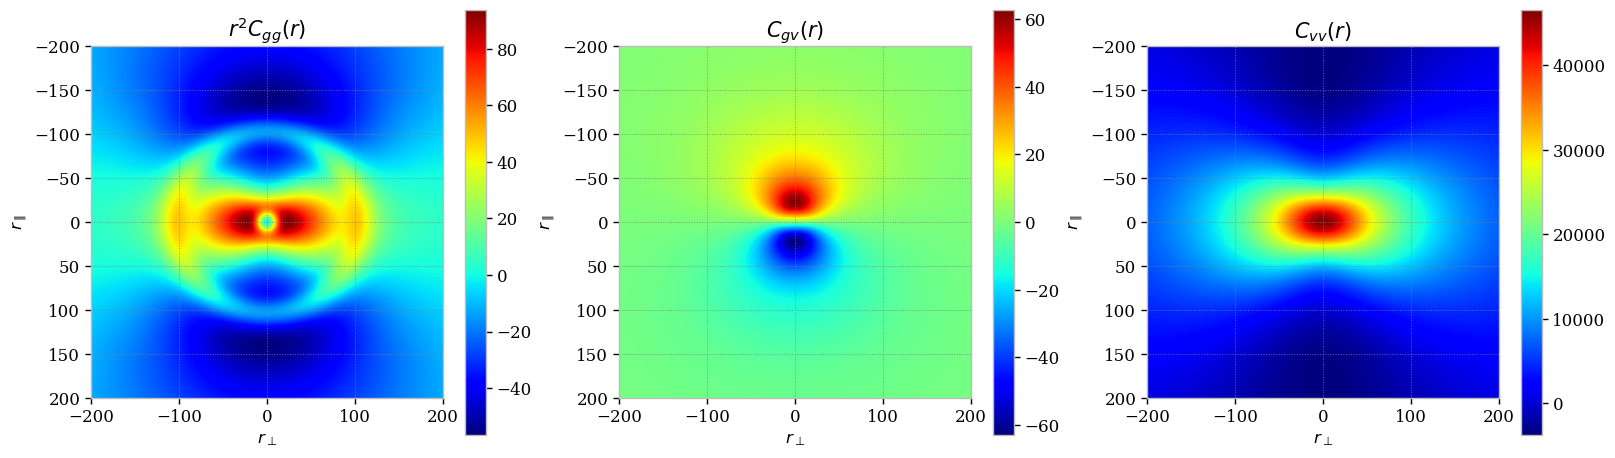

In [10]:

r_perpendicular = np.linspace(-200,200,200)
r_parallel = np.linspace(-200,200,200)

r_reference_parallel = 30 
r_reference_perpendicular = 0 

contraction_plot = contraction.Contraction.init_from_flip(
    "adamsblake20",
    "full",
    power_spectrum_dict,
    r_perpendicular,
    r_parallel,
    r_reference_perpendicular,
    r_reference_parallel,
    coordinate_type="rprt",
    additional_parameters_values=(sigmag_fiducial,),
)

parameter_values_dict = {parameters: parameter_dict[parameters]["value"] for parameters in parameter_dict}

plot_utils.plot_2d_contraction(contraction_plot, 
                    parameter_values_dict, 
                    rs_multiplied = True)
